# Clasificador de Propinas para Viajes en Taxi en NYC (2020)

Inspirado en la charla ["Keeping up with Machine Learning in Production"](https://github.com/shreyashankar/debugging-ml-talk) de [Shreya Shankar](https://twitter.com/sh_reya)


Este notebook muestra la construcción de un modelo de machine learning de juguete, usando datos de viajes de los taxis amarillos de Nueva York para el año 2020, [proporcionados por la NYC Taxi and Limousine Commission (TLC)](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

La idea es encontrar aquellos viajes donde la propina dejada por el pasajero fue alta, es decir, mayor al 20% del costo del viaje.

Para ello ajustaremos un modelo de classificación binaria RandomForest usando los datos de los viajes de enero de 2020. Probaremos el modelo resultante sobre los datos de los viajes de febrero de 2020. Compararemos el desempeño del modelo en ambos casos usando la métrica de [f1-score](https://en.wikipedia.org/wiki/F-score).

**Este notebook está construido para ser ejecutado en [Google Colab](https://colab.research.google.com/), al que podemos acceder de manera gratuita solo teniendo un usuario de Google (Gmail) y un navegador web. No es necesario instalar nada en el computador local.**

## Cargando las librerías necesarias

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

## Leemos los datos de enero 2020 (entrenamiento)

In [2]:
taxi = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-01.parquet')

In [3]:
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,None
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,None
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,None
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,None
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,None


In [4]:
taxi.shape

(6405008, 19)

In [5]:
print(f'min:{min(taxi.tpep_pickup_datetime)}, max:{max(taxi.tpep_pickup_datetime)} ')

min:2003-01-01 00:07:17, max:2021-01-02 01:12:10 


In [6]:
taxi.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

## Descripción del Dataset

El diccionario de los datos puede encontrarse [acá](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf):

| Field Name      | Description |
| ----------- | ----------- |
| VendorID      | A code indicating the TPEP provider that provided the record. 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.       |
| tpep_pickup_datetime   | The date and time when the meter was engaged.        |
| tpep_dropoff_datetime   | The date and time when the meter was disengaged.        |
| Passenger_count   | The number of passengers in the vehicle. This is a driver-entered value.      |
| Trip_distance   | The elapsed trip distance in miles reported by the taximeter.      |
| PULocationID   | TLC Taxi Zone in which the taximeter was engaged.      |
| DOLocationID   | TLC Taxi Zone in which the taximeter was disengaged      |
| RateCodeID   | The final rate code in effect at the end of the trip. 1= Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride     |
| Store_and_fwd_flag | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. Y= store and forward trip, N= not a store and forward trip |
| Payment_type | A numeric code signifying how the passenger paid for the trip. 1= Credit card, 2= Cash, 3= No charge, 4= Dispute, 5= Unknown, 6= Voided trip |
| Fare_amount | The time-and-distance fare calculated by the meter. |
| Extra | Miscellaneous extras and surcharges. Currently, this only includes the \$0.50 and \$1 rush hour and overnight charges. |
| MTA_tax | \$0.50 MTA tax that is automatically triggered based on the metered rate in use. |
| Improvement_surcharge | \$0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
| Tip_amount | Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip. |
| Total_amount | The total amount charged to passengers. Does not include cash tips. |

## Definimos las características con las que realizaremos la clasificación.

Las construiremos a continuación en la etapa de pre-procesamiento de los datos.

In [7]:
numeric_feat = [
    "pickup_weekday",
    "pickup_hour",
    'work_hours',
    "pickup_minute",
    "passenger_count",
    'trip_distance',
    'trip_time',
    'trip_speed'
]
categorical_feat = [
    "PULocationID",
    "DOLocationID",
    "RatecodeID",
]
features = numeric_feat + categorical_feat
EPS = 1e-7

In [8]:
def preprocess(df, target_col):

   # Basic cleaning
    df = df[df['fare_amount'] > 0].reset_index(drop=True)  # avoid divide-by-zero
    # add target
    df['tip_fraction'] = df['tip_amount'] / df['fare_amount']
    df[target_col] = df['tip_fraction'] > 0.2

    # add features
    df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute
    df['work_hours'] = (df['pickup_weekday'] >= 0) & (df['pickup_weekday'] <= 4) & (df['pickup_hour'] >= 8) & (df['pickup_hour'] <= 18)
    df['trip_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds
    df['trip_speed'] = df['trip_distance'] / (df['trip_time'] + EPS)

    # drop unused columns
    df = df[['tpep_dropoff_datetime'] + features + [target_col]]
    df[features + [target_col]] = df[features + [target_col]].astype("float32").fillna(-1.0)

    # convert target to int32 for efficiency (it's just 0s and 1s)
    df[target_col] = df[target_col].astype("int32")

    return df.reset_index(drop=True)


In [9]:
target_col = "high_tip"

taxi_train = preprocess(df=taxi, target_col=target_col)

In [10]:
taxi_train.head()

,tpep_dropoff_datetime,pickup_weekday,pickup_hour,work_hours,pickup_minute,passenger_count,trip_distance,trip_time,trip_speed,PULocationID,DOLocationID,RatecodeID,high_tip
0,2020-01-01 00:33:03,2.0,0.0,0.0,28.0,1.0,1.2,288.0,0.004167,238.0,239.0,1.0,1
1,2020-01-01 00:43:04,2.0,0.0,0.0,35.0,1.0,1.2,445.0,0.002697,239.0,238.0,1.0,1
2,2020-01-01 00:53:52,2.0,0.0,0.0,47.0,1.0,0.6,371.0,0.001617,238.0,238.0,1.0,0
3,2020-01-01 01:00:14,2.0,0.0,0.0,55.0,1.0,0.8,291.0,0.002749,238.0,151.0,1.0,1
4,2020-01-01 00:04:16,2.0,0.0,0.0,1.0,1.0,0.0,138.0,0.000000,193.0,193.0,1.0,0


In [11]:
print(f'Num rows: {len(taxi_train)}, Size: {taxi_train.memory_usage(deep=True).sum() / 1e9} GB')

Num rows: 6382762, Size: 0.3574348 GB


## Ajustamos el modelo con los datos de entrenamiento

Este proceso se puede demorar bastante (¡en mi caso fueron 30 minutos!), pero podemos realizar una prueba mas pequeña reduciendo la cantidad de ejemplos de entrenamiento. Por ejemplo podríamos agregar la siguiente celda para entrenar con una muestra aleatoria de 1.000.000:

`taxi_train = taxi_train.sample(1000000)`

In [12]:
taxi_train = taxi_train.sample(1000000)

In [13]:
taxi_train.to_csv('taxi_train_1000000_filas.csv', index=False)

In [14]:
%%time

rfc = RandomForestClassifier(n_estimators=100, max_depth=10)

rfc.fit(taxi_train[features], taxi_train[target_col])

CPU times: user 2min 56s, sys: 184 ms, total: 2min 57s
Wall time: 2min 58s


RandomForestClassifier(max_depth=10)

## Calculamos la métrica f1-score en el conjunto de entrenamiento

In [15]:
%%time
# Compute F1

preds = rfc.predict_proba(taxi_train[features])

CPU times: user 11.7 s, sys: 24.2 ms, total: 11.8 s
Wall time: 11.9 s


In [16]:
len(preds)

1000000

In [17]:
preds #arroja 2 valores pues el primero es la probabilidad de que high_tio sea = 0, y el segundo la prob. de que high_tip sea = 1

array([[0.37473589, 0.62526411],
       [0.34630826, 0.65369174],
       [0.46340646, 0.53659354],
       ...,
       [0.38171012, 0.61828988],
       [0.42477378, 0.57522622],
       [0.47126018, 0.52873982]])

In [18]:
type(preds)

numpy.ndarray

In [19]:
preds_labels = [p[1] for p in preds.round()]

In [20]:
preds_labels[0:10]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [21]:
print(f'F1: {f1_score(taxi_train[target_col], preds_labels)}')

F1: 0.7314357396571152


## Exportamos el modelo a un archivo

In [34]:
import joblib

joblib.dump(rfc, "random_forest.joblib")

['random_forest.joblib']

El archivo aparecerá en el menú del lado izquierdo, como se muestra en la foto. Podemos guardarlo en nuestro equipo usando boton derecho -> Download. Será útil hacerlo porque lo seguiremos usando en el futuro.

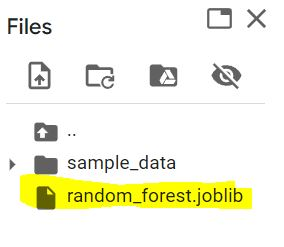

## Cargamos los datos de febrero 2020 (prueba)

In [23]:
taxi_feb = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-02.parquet')
taxi_test = preprocess(taxi_feb, target_col=target_col)
taxi_test.head()

,tpep_dropoff_datetime,pickup_weekday,pickup_hour,work_hours,pickup_minute,passenger_count,trip_distance,trip_time,trip_speed,PULocationID,DOLocationID,RatecodeID,high_tip
0,2020-02-01 00:30:32,5.0,0.0,0.0,17.0,1.0,2.60,777.0,0.003346,145.0,7.0,1.0,1
1,2020-02-01 01:05:36,5.0,0.0,0.0,32.0,1.0,4.80,1969.0,0.002438,45.0,61.0,1.0,1
2,2020-02-01 00:43:28,5.0,0.0,0.0,31.0,1.0,3.20,704.0,0.004545,186.0,140.0,1.0,0
3,2020-02-01 00:31:39,5.0,0.0,0.0,7.0,1.0,4.38,1444.0,0.003033,144.0,140.0,1.0,0
4,2020-02-01 01:01:29,5.0,0.0,0.0,51.0,1.0,2.28,586.0,0.003891,238.0,152.0,1.0,0


In [24]:
taxi_test.shape

(6276854, 13)

## Cargamos el modelo que guardamos y realizamos predicciones de prueba

In [25]:
loaded_rfc = joblib.load("random_forest.joblib")

In [26]:
%%time
# Compute F1
# This is (relatively) slow since we are copying data to the CPU to compute the metric.

preds_test = loaded_rfc.predict_proba(taxi_test[features])

CPU times: user 1min 2s, sys: 82.7 ms, total: 1min 3s
Wall time: 1min 5s


In [27]:
preds_test_labels = [p[1] for p in preds_test.round()]
print(f'F1: {f1_score(taxi_test[target_col], preds_test_labels)}')

F1: 0.7349927704696302


In [28]:
taxi_mar = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-03.parquet')
taxi_test = preprocess(taxi_mar, target_col=target_col)
taxi_test.head()

,tpep_dropoff_datetime,pickup_weekday,pickup_hour,work_hours,pickup_minute,passenger_count,trip_distance,trip_time,trip_speed,PULocationID,DOLocationID,RatecodeID,high_tip
0,2020-03-01 01:01:42,6.0,0.0,0.0,31.0,1.0,4.70,1829.0,0.002570,88.0,255.0,1.0,0
1,2020-03-01 00:08:49,6.0,0.0,0.0,8.0,1.0,0.00,27.0,0.000000,193.0,193.0,1.0,0
2,2020-03-01 00:59:16,6.0,0.0,0.0,52.0,1.0,1.10,418.0,0.002632,246.0,90.0,1.0,1
3,2020-03-01 00:50:57,6.0,0.0,0.0,47.0,2.0,0.87,184.0,0.004728,151.0,238.0,1.0,1
4,2020-03-01 00:58:27,6.0,0.0,0.0,43.0,0.0,4.40,908.0,0.004846,79.0,261.0,1.0,1


In [29]:
preds_test = loaded_rfc.predict_proba(taxi_test[features])
preds_test_labels = [p[1] for p in preds_test.round()]
print(f'F1: {f1_score(taxi_test[target_col], preds_test_labels)}')

F1: 0.725934609337867


In [32]:
taxi_abr = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-04.parquet')
taxi_test = preprocess(taxi_abr, target_col=target_col)
taxi_test.head()

,tpep_dropoff_datetime,pickup_weekday,pickup_hour,work_hours,pickup_minute,passenger_count,trip_distance,trip_time,trip_speed,PULocationID,DOLocationID,RatecodeID,high_tip
0,2020-04-01 01:01:53,2.0,0.0,0.0,41.0,1.0,1.20,1231.0,0.000975,41.0,24.0,1.0,0
1,2020-04-01 01:09:25,2.0,0.0,0.0,56.0,1.0,3.40,805.0,0.004224,95.0,197.0,1.0,1
2,2020-04-01 00:09:25,2.0,0.0,0.0,0.0,1.0,2.80,539.0,0.005195,237.0,137.0,1.0,0
3,2020-04-01 00:34:38,2.0,0.0,0.0,24.0,0.0,2.60,600.0,0.004333,68.0,142.0,1.0,0
4,2020-04-01 00:18:26,2.0,0.0,0.0,13.0,1.0,1.44,302.0,0.004768,263.0,74.0,1.0,1


In [33]:
preds_test = loaded_rfc.predict_proba(taxi_test[features])
preds_test_labels = [p[1] for p in preds_test.round()]
print(f'F1: {f1_score(taxi_test[target_col], preds_test_labels)}')

F1: 0.6117247729611642


In [36]:
taxi_may = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-05.parquet')
taxi_test = preprocess(taxi_may, target_col=target_col)
taxi_test.head()

,tpep_dropoff_datetime,pickup_weekday,pickup_hour,work_hours,pickup_minute,passenger_count,trip_distance,trip_time,trip_speed,PULocationID,DOLocationID,RatecodeID,high_tip
0,2020-05-01 00:18:07,4.0,0.0,0.0,2.0,1.0,0.0,939.0,0.000000,234.0,256.0,1.0,0
1,2020-05-01 00:26:01,4.0,0.0,0.0,23.0,2.0,0.4,160.0,0.002500,264.0,264.0,1.0,0
2,2020-05-01 00:57:11,4.0,0.0,0.0,54.0,1.0,0.3,133.0,0.002256,264.0,264.0,1.0,0
3,2020-05-01 00:12:46,4.0,0.0,0.0,7.0,1.0,1.7,336.0,0.005060,107.0,229.0,1.0,0
4,2020-05-01 01:01:54,4.0,0.0,0.0,55.0,0.0,0.9,367.0,0.002452,237.0,262.0,1.0,0


In [37]:
preds_test = loaded_rfc.predict_proba(taxi_test[features])
preds_test_labels = [p[1] for p in preds_test.round()]
print(f'F1: {f1_score(taxi_test[target_col], preds_test_labels)}')

F1: 0.6166028484960244


**Vemos que el F1 bajó de 0,73 a 0,61  al testear el modelo en Abr-2024**

## Intentemos realizar la predicción de un solo viaje

Necesitaremos hacer algo así más adelante

In [ ]:
taxi_test.head(1)[features].iloc[0].values #elijo la primera fila del df, sólo columnas de interés y tomo los valores y los guardo en un array

array([5.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.7000000e+01,
       1.0000000e+00, 2.5999999e+00, 7.7700000e+02, 3.3462034e-03,
       1.4500000e+02, 7.0000000e+00, 1.0000000e+00], dtype=float32)

In [ ]:
taxi_test.head(1)[target_col].iloc[0] #para la primera fila, por ej., la variable target es 1

1

In [ ]:
#Si aplico modelo a la primera fila, me da 0,54, que al redondear, da 1:
loaded_rfc.predict_proba(taxi_test.head(1)[features].iloc[0].values.reshape(1, -1))[0][1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.5485961619350269